<a href="https://colab.research.google.com/github/Naresh-812/Introduction_to_ML/blob/main/paddy_cnn2_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Sequential ,load_model
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
import cv2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

# Step 1: Copy test folder to working directory
src = '/content/drive/MyDrive/Rice_Leaf_Diease/Rice_Leaf_Diease/test'
dst = '/content/drive/MyDrive/Rice_Leaf_Diease/Rice_Leaf_Diease/test_fixed1'

# Copy directory tree
shutil.copytree(src, dst)

# Step 2: Rename inside working directory
rename_map = {
    'Neck_Blast': 'neck_blast',
    'Rice Hispa': 'rice_hispa',
    'Sheath Blight': 'sheath_blight',
    'Tungro': 'tungro'
}

for old_name, new_name in rename_map.items():
    old_path = os.path.join(dst, old_name)
    new_path = os.path.join(dst, new_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed: {old_name} ➝ {new_name}")
    else:
        print(f"Folder not found: {old_name}")


Renamed: Neck_Blast ➝ neck_blast
Renamed: Rice Hispa ➝ rice_hispa
Renamed: Sheath Blight ➝ sheath_blight
Renamed: Tungro ➝ tungro


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
img_size = 224  # or your preferred size
batch_size = 32
train_dir = '/content/drive/MyDrive/Rice_Leaf_Diease/Rice_Leaf_Diease/train'
#test_dir = '/kaggle/input/paddy-disease/rice_disease_data/test'

# Create training and validation ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training'  # Subset for training
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation'  # Subset for validation
)

# Testing generator
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Rice_Leaf_Diease/Rice_Leaf_Diease/test_fixed1',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 11600 images belonging to 10 classes.
Found 2900 images belonging to 10 classes.
Found 3500 images belonging to 10 classes.


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tqdm import tqdm
import random
dataset_path = '/content/drive/MyDrive/Rice_Leaf_Diease/Rice_Leaf_Diease/train'
target_size = 224  # Adjust according to your model (e.g., 224 for VGG, 227 for AlexNet)
TARGET_IMAGES = 1450

# ImageDataGenerator for augmentation
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Process each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(image_files)

    print(f"\n🔍 Class '{class_name}': {current_count} images")
    if current_count > TARGET_IMAGES:
        print(f"⚠️ Too many images. Downsampling to {TARGET_IMAGES}...")
        random.shuffle(image_files)
        keep_files = image_files[:TARGET_IMAGES]
        delete_files = set(image_files) - set(keep_files)

        for file_name in delete_files:
            try:
                os.remove(os.path.join(class_path, file_name))
            except Exception as e:
                print(f"Error deleting {file_name}: {e}")
        print(f"✅ Downsampled '{class_name}' to {TARGET_IMAGES} images.")

    # ----------- CASE 2: Augment if fewer than needed -----------
    elif current_count < TARGET_IMAGES:
        needed = TARGET_IMAGES - current_count
        print(f"🔄 Generating {needed} new images...")

        i = 0
        pbar = tqdm(total=needed, desc=f"Augmenting '{class_name}'")
        while i < needed:
            for img_name in image_files:
                img_path = os.path.join(class_path, img_name)
                try:
                    img = load_img(img_path, target_size=(target_size, target_size))
                    x = img_to_array(img)
                    x = np.expand_dims(x, axis=0)

                    aug_iter = augmenter.flow(x, batch_size=1)
                    aug_img = next(aug_iter)[0].astype(np.uint8)

                    save_name = f"aug_{i}_{img_name}"
                    save_path = os.path.join(class_path, save_name)
                    save_img(save_path, aug_img)

                    i += 1
                    pbar.update(1)

                    if i >= needed:
                        break
                except Exception as e:
                    print(f"Error processing {img_name}: {e}")
                    continue
        pbar.close()
        print(f"✅ Augmentation complete for class '{class_name}'.")

    # ----------- CASE 3: Already balanced -----------
    else:
        print("✅ Already has exactly 1450 images. Skipping.")

    print(f"✅ Augmentation complete for class '{class_name}'.")


🔍 Class 'neck_blast': 1450 images
✅ Already has exactly 1450 images. Skipping.
✅ Augmentation complete for class 'neck_blast'.

🔍 Class 'rice_hispa': 1461 images
⚠️ Too many images. Downsampling to 1450...
✅ Downsampled 'rice_hispa' to 1450 images.
✅ Augmentation complete for class 'rice_hispa'.

🔍 Class 'tungro': 1740 images
⚠️ Too many images. Downsampling to 1450...
✅ Downsampled 'tungro' to 1450 images.
✅ Augmentation complete for class 'tungro'.

🔍 Class 'narrow_brown_spot': 1450 images
✅ Already has exactly 1450 images. Skipping.
✅ Augmentation complete for class 'narrow_brown_spot'.

🔍 Class 'brown_spot': 1480 images
⚠️ Too many images. Downsampling to 1450...
✅ Downsampled 'brown_spot' to 1450 images.
✅ Augmentation complete for class 'brown_spot'.

🔍 Class 'leaf_scald': 1670 images
⚠️ Too many images. Downsampling to 1450...
✅ Downsampled 'leaf_scald' to 1450 images.
✅ Augmentation complete for class 'leaf_scald'.

🔍 Class 'bacterial_leaf_blight': 1450 images
✅ Already has ex

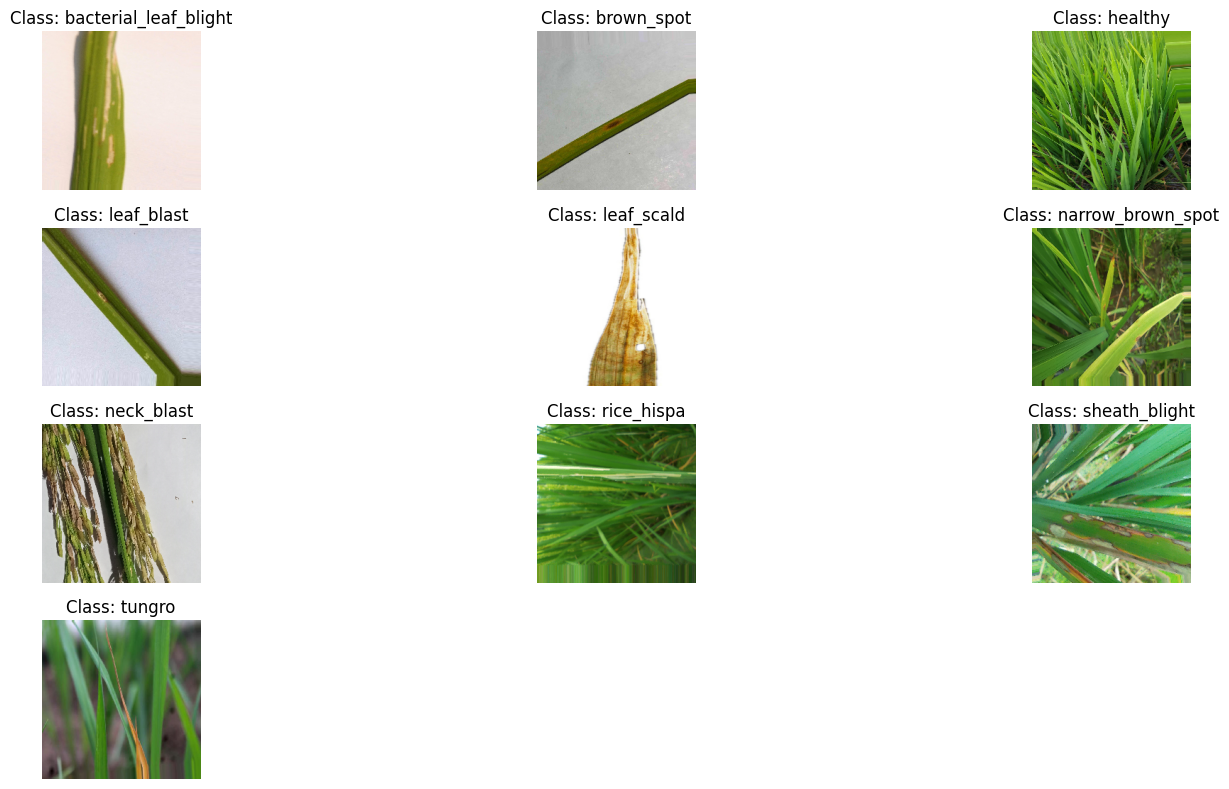

In [ ]:
import random
# Automatically get class folder names
class_names= ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']

# Plot one random image from each class folder
plt.figure(figsize=(15, 8))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    if not image_files:
        print(f"No images found in {class_name}")
        continue

    # Randomly select one image
    selected_image = random.choice(image_files)
    img_path = os.path.join(class_path, selected_image)
    img = load_img(img_path, target_size=(img_size,img_size,3))

    plt.subplot(4, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tqdm import tqdm
import shutil

# PARAMETERS
dataset_path = '/content/drive/MyDrive/Rice_Leaf_Diease/Rice_Leaf_Diease/test_fixed1'
target_size = 224
TARGET_IMAGES = 350

# Data augmenter
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)

    print(f"\n🔍 Class '{class_name}': {current_count} images")

    # ----------- CASE 1: Downsample if more than needed -----------
    if current_count > TARGET_IMAGES:
        print(f"⚠️ Too many images. Downsampling to {TARGET_IMAGES}...")
        random.shuffle(image_files)
        keep_files = image_files[:TARGET_IMAGES]
        delete_files = set(image_files) - set(keep_files)

        for file_name in delete_files:
            try:
                os.remove(os.path.join(class_path, file_name))
            except Exception as e:
                print(f"Error deleting {file_name}: {e}")
        print(f"✅ Downsampled '{class_name}' to {TARGET_IMAGES} images.")

    # ----------- CASE 2: Augment if fewer than needed -----------
    elif current_count < TARGET_IMAGES:
        needed = TARGET_IMAGES - current_count
        print(f"🔄 Generating {needed} new images...")

        i = 0
        pbar = tqdm(total=needed, desc=f"Augmenting '{class_name}'")
        while i < needed:
            for img_name in image_files:
                img_path = os.path.join(class_path, img_name)
                try:
                    img = load_img(img_path, target_size=(target_size, target_size))
                    x = img_to_array(img)
                    x = np.expand_dims(x, axis=0)

                    aug_iter = augmenter.flow(x, batch_size=1)
                    aug_img = next(aug_iter)[0].astype(np.uint8)

                    save_name = f"aug_{i}_{img_name}"
                    save_path = os.path.join(class_path, save_name)
                    save_img(save_path, aug_img)

                    i += 1
                    pbar.update(1)

                    if i >= needed:
                        break
                except Exception as e:
                    print(f"Error processing {img_name}: {e}")
                    continue
        pbar.close()
        print(f"✅ Augmentation complete for class '{class_name}'.")

    # ----------- CASE 3: Already balanced -----------
    else:
        print("✅ Already has exactly 350 images. Skipping.")



🔍 Class 'sheath_blight': 288 images
🔄 Generating 62 new images...


Augmenting 'sheath_blight': 100%|██████████| 62/62 [00:03<00:00, 15.65it/s]


✅ Augmentation complete for class 'sheath_blight'.

🔍 Class 'narrow_brown_spot': 382 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'narrow_brown_spot' to 350 images.

🔍 Class 'brown_spot': 380 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'brown_spot' to 350 images.

🔍 Class 'rice_hispa': 225 images
🔄 Generating 125 new images...


Augmenting 'rice_hispa': 100%|██████████| 125/125 [00:06<00:00, 18.84it/s]


✅ Augmentation complete for class 'rice_hispa'.

🔍 Class 'leaf_scald': 386 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'leaf_scald' to 350 images.

🔍 Class 'tungro': 310 images
🔄 Generating 40 new images...


Augmenting 'tungro': 100%|██████████| 40/40 [00:01<00:00, 20.26it/s]


✅ Augmentation complete for class 'tungro'.

🔍 Class 'bacterial_leaf_blight': 376 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'bacterial_leaf_blight' to 350 images.

🔍 Class 'leaf_blast': 362 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'leaf_blast' to 350 images.

🔍 Class 'healthy': 391 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'healthy' to 350 images.

🔍 Class 'neck_blast': 322 images
🔄 Generating 28 new images...


Augmenting 'neck_blast': 100%|██████████| 28/28 [00:02<00:00, 10.12it/s]

✅ Augmentation complete for class 'neck_blast'.


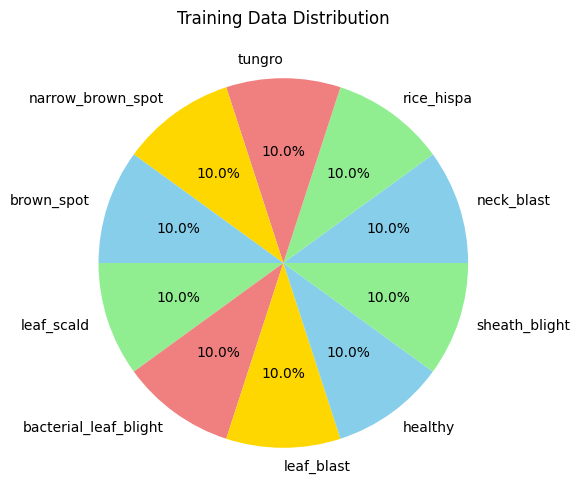

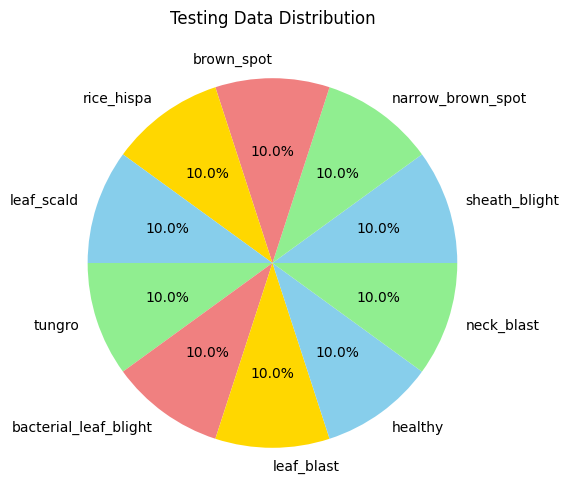

Training Data Counts:
neck_blast: 1450 images
rice_hispa: 1450 images
tungro: 1450 images
narrow_brown_spot: 1450 images
brown_spot: 1450 images
leaf_scald: 1450 images
bacterial_leaf_blight: 1450 images
leaf_blast: 1450 images
healthy: 1450 images
sheath_blight: 1450 images

Testing Data Counts:
sheath_blight: 350 images
narrow_brown_spot: 350 images
brown_spot: 350 images
rice_hispa: 350 images
leaf_scald: 350 images
tungro: 350 images
bacterial_leaf_blight: 350 images
leaf_blast: 350 images
healthy: 350 images
neck_blast: 350 images


In [ ]:
# Function to count images in each class
def count_images(dataset_path):
    class_counts = {}
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            num_images = len(os.listdir(label_path))
            class_counts[label] = num_images
    return class_counts

# Count images in training and testing datasets
train_counts = count_images(train_dir)
test_counts = count_images('/content/drive/MyDrive/Rice_Leaf_Diease/Rice_Leaf_Diease/test_fixed1')

# Plot pie charts
def plot_pie_chart(class_counts, title):
    labels = list(class_counts.keys())
    sizes = list(class_counts.values())
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0, colors=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title(title)
    plt.show()

# Plot for training data
plot_pie_chart(train_counts, "Training Data Distribution")

# Plot for testing data
plot_pie_chart(test_counts, "Testing Data Distribution")

# Print the number of images in each class
print("Training Data Counts:")
for label, count in train_counts.items():
    print(f"{label}: {count} images")

print("\nTesting Data Counts:")
for label, count in test_counts.items():
    print(f"{label}: {count} images")

In [ ]:
# Define CNN model for leaf disease classification
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization,GlobalAveragePooling2D


model = Sequential()

# Define the input shape based on the image size and color channels
# img_size = 128 # Change this
img_size = 224 # To match the ImageDataGenerator target_size
input_shape = (img_size, img_size, 3)

# First Convolutional Block
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(SeparableConv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block
model.add(SeparableConv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 109, 109, 32)   │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 24, 24, 32)     │         5,280 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,922 (198.91 KB)

 Trainable params: 50,474 (197.16 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


In [ ]:


plot_model(model, to_file='paddy_leaf_cnn_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

# Display block diagram
try:
    display(Image(filename='paddy_leaf_cnn_model.png'))
except NameError: # Catch NameError if Image is not defined
    print("Model plot saved as 'paddy_leaf_cnn_model.png'")

TypeError: 'module' object is not callable

In [ ]:
import os
from PIL import Image

broken = 0
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    for fname in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, fname)
            img = Image.open(img_path)  # Try opening image
            img.verify()  # Check if corrupted
        except Exception as e:
            broken += 1
            print(f"Removing broken image: {img_path}")
            os.remove(img_path)

print(f"Total broken images removed: {broken}")


Total broken images removed: 0


In [ ]:
print(os.listdir('/content/drive/MyDrive/Rice_Leaf_Diease/Rice_Leaf_Diease/train/tungro')[:5])


['tungro1506.jpg', 'tungro209.jpg', 'tungro1718.jpg', 'tungro1382.jpg', 'tungro1351.jpg']


In [ ]:
# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',


    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=35,
    validation_data=validation_generator ,
    validation_steps=validation_generator .samples //validation_generator .batch_size,
    verbose=1,callbacks=([lr_reduce])
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
362/362 ━━━━━━━━━━━━━━━━━━━━ 355s 923ms/step - accuracy: 0.5440 - loss: 1.3748 - val_accuracy: 0.1792 - val_loss: 2.2119 - learning_rate: 0.0010
Epoch 2/35
  1/362 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9375 - loss: 0.4189

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


362/362 ━━━━━━━━━━━━━━━━━━━━ 88s 243ms/step - accuracy: 0.9375 - loss: 0.4189 - val_accuracy: 0.1823 - val_loss: 2.2057 - learning_rate: 0.0010
Epoch 3/35
362/362 ━━━━━━━━━━━━━━━━━━━━ 312s 862ms/step - accuracy: 0.7649 - loss: 0.6906 - val_accuracy: 0.7434 - val_loss: 0.7057 - learning_rate: 0.0010
Epoch 4/35
362/362 ━━━━━━━━━━━━━━━━━━━━ 48s 132ms/step - accuracy: 0.7812 - loss: 0.6973 - val_accuracy: 0.6066 - val_loss: 1.0348 - learning_rate: 0.0010
Epoch 5/35
362/362 ━━━━━━━━━━━━━━━━━━━━ 383s 997ms/step - accuracy: 0.8112 - loss: 0.5497 - val_accuracy: 0.6615 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 6/35
  1/362 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8438 - loss: 0.3268
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
362/362 ━━━━━━━━━━━━━━━━━━━━ 72s 200ms/step - accuracy: 0.8438 - loss: 0.3268 - val_accuracy: 0.6438 - val_loss: 1.3792 - learning_rate: 0.0010
Epoch 7/35
362/362 ━━━━━━━━━━━━━━━━━━━━ 330s 887ms/step - accuracy: 0.8535 - loss

91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 435ms/step - accuracy: 0.9467 - loss: 0.1640
Test Accuracy: 94.48%


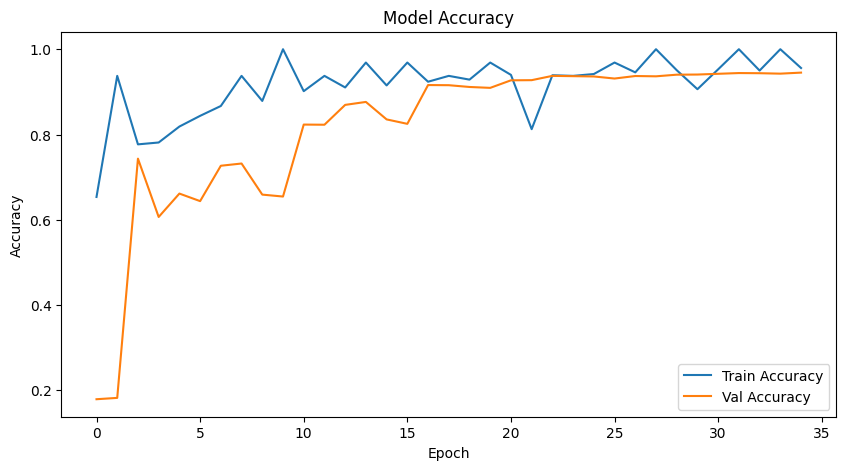

In [ ]:
loss, acc = model.evaluate(validation_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Plot accuracy graph

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


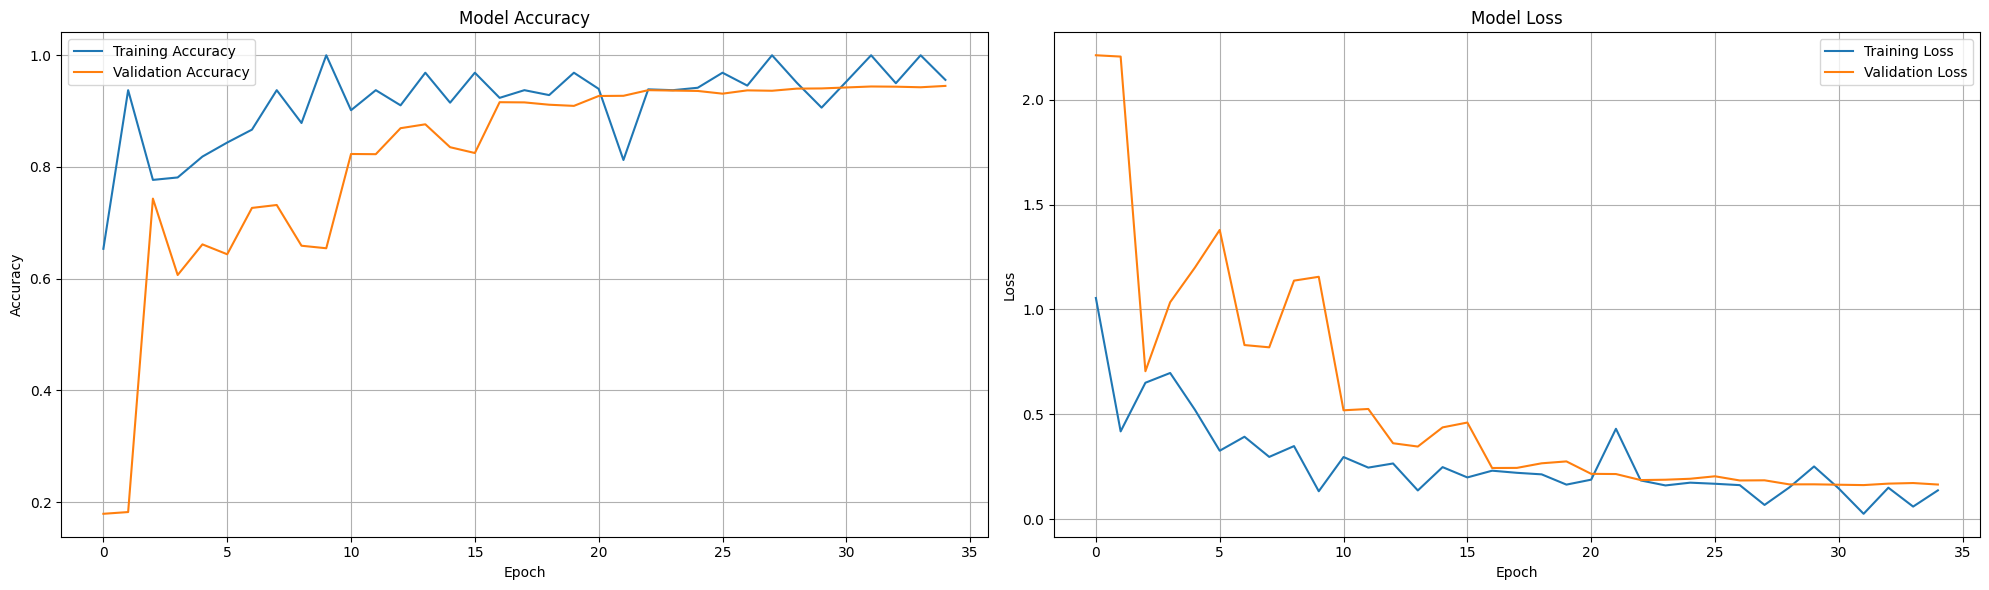

In [ ]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(20,6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/trained _models/paddy_basic_cnn_leaf__model.h5')


In [ ]:
# Accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

# Loss
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Training Accuracy:   {train_acc * 100:.2f}%")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss:     {val_loss:.4f}")


Training Accuracy:   95.59%
Training Loss:       0.1378
Validation Accuracy: 94.51%
Validation Loss:     0.1656


In [ ]:
correct = 0
total = 0

for i in range(len(test_generator)):
    try:
        x, y_true = test_generator[i]
        y_pred = model.predict(x)
        correct += np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
        total += x.shape[0]
    except Exception as e:
        print(f"Skipping batch {i} due to error: {e}")

print(f"Test Accuracy: {(correct / total) * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

Found 11600 images belonging to 10 classes.
Found 2900 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 50s 544ms/step


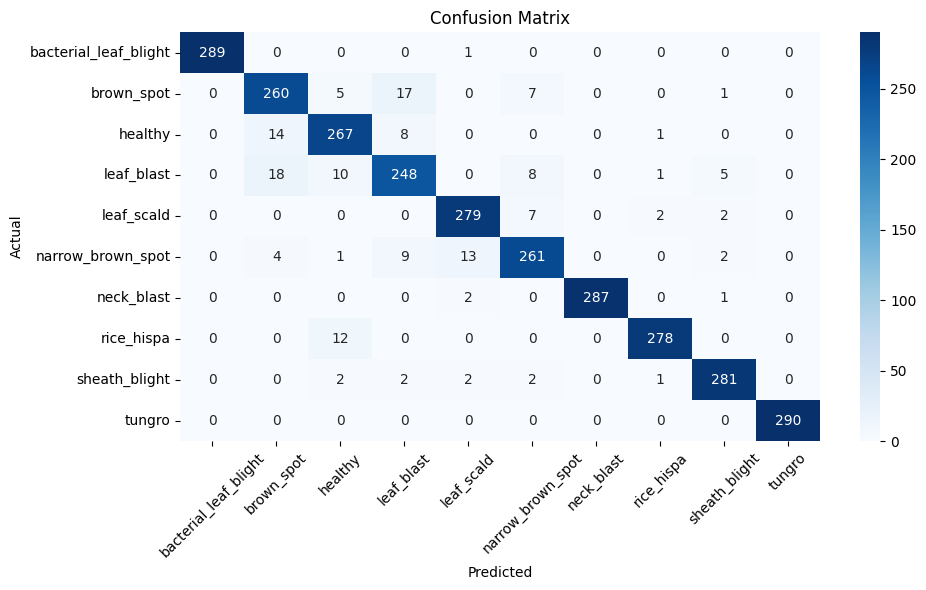


Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00       290
           brown_spot       0.88      0.90      0.89       290
              healthy       0.90      0.92      0.91       290
           leaf_blast       0.87      0.86      0.86       290
           leaf_scald       0.94      0.96      0.95       290
    narrow_brown_spot       0.92      0.90      0.91       290
           neck_blast       1.00      0.99      0.99       290
           rice_hispa       0.98      0.96      0.97       290
        sheath_blight       0.96      0.97      0.97       290
               tungro       1.00      1.00      1.00       290

             accuracy                           0.94      2900
            macro avg       0.95      0.94      0.94      2900
         weighted avg       0.95      0.94      0.94      2900



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Ensure validation_generator is not shuffled ---
# If not already done earlier, re-define it here with shuffle=False
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training'  # Subset for training
)
# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation' ,
    shuffle=False
)

# --- Get true labels from validation set ---
Y_true = validation_generator.classes

# --- Predict class probabilities using the trained model ---
# Cast the result of np.ceil to an integer for the 'steps' argument
Y_pred_probs = model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / validation_generator.batch_size)))

# --- Get predicted class indices ---
Y_pred = np.argmax(Y_pred_probs, axis=1)

# --- Get class names ---
class_names = list(validation_generator.class_indices.keys())

# --- Generate the confusion matrix ---
cm = confusion_matrix(Y_true, Y_pred)

# --- Plot the confusion matrix ---
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Print classification report ---
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_names))

In [ ]:
print("Y_true shape:", Y_true.shape)
print("Y_pred_probs shape:", Y_pred_probs.shape)
print("Y_pred shape:", Y_pred.shape)


Y_true shape: (2900,)
Y_pred_probs shape: (2900, 10)
Y_pred shape: (2900,)
